# Data processing

Prepare the single cell and untargeted spatial transcriptomics datasets.

**Datasets**:


- human lung scRNA-seq
    - Madissoon2020, 
    - Krasnow2021, 
    - Meyer2022, 
- developing human heart 
    - Asp2019 scRNAseq
    - Asp2019 untargeted ST
- adult human heart 
    - Litvinukova2020


**The final datasets include**:
- adata.X: raw integer counts
- adata.obs:
    - cell type keys
    - size factors: 
        - size_factors (from scran normalisation)
        - size_factors_target_sum_10000 (from normalise_total)
- adata.var:
    - highly variable genes:
        - highly_variable_{n} for n in [8000,6000,4000,2000,1000,500]
    - quantiles:
        - expression quantiles
    - expression penalties (note that these are added at the end of the notebook) #TODO: potentially embed this in the dataset specific parts
        
**requirements**:
- To run this notebook use the following [docker container](https://hub.docker.com/r/leanderd/single-cell-analysis)

# Inputs

- The raw data is expected to be located at `DATA_DIR+"raw"`
- The processed data will be located at `DATA_DIR+"processed"`
--> adjust `DATA_DIR` to your local settings

In [1]:
# Adjust the following 
DATA_DIR = "/lustre/groups/ml01/workspace/louis.kuemmerle/projects/G1/data/"

In [2]:
import os
import pandas as pd
import anndata as ann
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from importlib import reload
sc.settings.verbosity = 3

# silence NumbaPerformanceWarning
import warnings
try:
    from numba.core.errors import NumbaPerformanceWarning
    warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
except:
    print("Ignore NumbaPerformanceWarning didn't work")

# Functions

In [3]:
def scran_normalization_size_factor(adata, min_mean = 0.1):
    # rpy2 for running R code
    import rpy2.rinterface_lib.callbacks
    import logging
    rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Ignore R warning messages
    import rpy2.robjects as ro
    import anndata2ri
    from scipy import sparse
    
    anndata2ri.activate()
    ro.r('library("scran")')
    
    # Preliminary clustering for differentiated normalisation
    adata_pp = adata.copy()
    sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)
    
    ro.globalenv['data_mat'] = adata.X.T
    ro.globalenv['input_groups'] = adata_pp.obs['groups']
    size_factors = ro.r(f'calculateSumFactors(data_mat, clusters = input_groups, min.mean = {min_mean})')
    del adata_pp
    return size_factors

def calculate_size_factors(adata,normalisation='scran',key_added='size_factors'):  
    if normalisation=='cpm':
        tmp = sc.pp.normalize_total(adata,target_sum=1e6,inplace=False)
        adata.obs[key_added] = tmp['norm_factor']/10**6
    elif normalisation=='scran':
        adata.obs[key_added] = scran_normalization_size_factor(adata, min_mean = 0.1)
        
def get_highly_variable(adata,N=8000,key_added='highly_variable'):
    """Compute N highly variable genes of given dataset for given normalisation
    
    A copy of the raw data is normalised and log1p transformed to extract N highly variable genes.
    """
    a = adata.copy()
    a.X /= a.obs['size_factors'].values[:,None]
    sc.pp.log1p(a) 
    sc.pp.highly_variable_genes(a, n_top_genes=N, flavor='cell_ranger', inplace=True)
    adata.var[key_added] = a.var['highly_variable']
    
def split_train_test_sets(adata,split=4,seed=2020):
    """Split data to train and test set"""
    n_train = (adata.n_obs//(split+1))*split
    
    np.random.seed(seed=seed)
    train_obs = np.random.choice(adata.n_obs, n_train, replace=False)
    test_obs = np.array([True for i in range(adata.n_obs)])
    test_obs[train_obs] = False
    train_obs = np.invert(test_obs)
    
    print(f"Split data to ratios {split}:1 (train:test)")
    print(f"datapoints: {adata.n_obs}")
    print(f"train data: {np.sum(train_obs)}")
    print(f"test data: {np.sum(test_obs)}")
    
    adata.obs['train_set'] = train_obs
    adata.obs['test_set'] = test_obs
    
def gene_mean_and_std(adata):
    """Calculate mean and std of genes for optional zscoring 
    
    adata: anndata object
        The adata should contain raw integer counts (adata.X) and a size factor according some normalisation
        procedure (adata.obs['size_factors']).
    """
    adata_tmp = adata.copy()
    # normalise
    adata_tmp.X /= adata_tmp.obs['size_factors'].values[:,None]
    # log1p
    sc.pp.log1p(adata_tmp)
    adata.var['mean'] = np.mean(adata_tmp.X,axis=0)
    adata.var['std'] = np.std(adata_tmp.X,axis=0)    
        
        
def get_expression_quantile(adata,q=0.9,log1p=True,zeros_to_nan=False):
    """Compute each genes q'th quantile on normalised (and log1p) data 
    
    dataset: str or AnnData 
        AnnData needs to contain raw counts (adata.X) and some size factor (adata.obs['size_factors'])
    log1p: bool
        log1p the data to get quantile values of log data.
    zeros_to_nan: bool
        Don't include zeros into quantile calculation
    """
    a = adata.copy() 
    a.X /= a.obs['size_factors'].values[:,None]
    if log1p:
        sc.pp.log1p(a)
    df = pd.DataFrame(a.X,index=a.obs.index,columns=a.var.index)
    if zeros_to_nan:
        df[df==0] = np.nan
    quantiles = df.quantile(q)
    if zeros_to_nan:
        adata.var[f'pos_quantile_{q}'] = df.quantile(q)
    else:
        adata.var[f'quantile_{q}'] = df.quantile(q)
    
    
def get_umap(adata,key_added="X_umap",hvg_key="highly_variable"):
    """Compute pca, knn graph and umap, save umap only
    """
    # preprocessing
    if hvg_key:
        a = adata[:,adata.var[hvg_key]].copy()
    else:
        a = adata.copy()
    a.X /= a.obs['size_factors'].values[:,None]
    sc.pp.log1p(a)
    # umap calculation
    sc.tl.pca(a)
    sc.pp.neighbors(a)
    sc.tl.umap(a)
    # add to adata
    adata.obsm[key_added] = a.obsm["X_umap"]

# Dataset A, Madissoon 2019

In [4]:
adata = sc.read(DATA_DIR+"raw/Meyer_Krasnow_raw.h5ad") #TODO: adjust to Madissoon raw instead of HLCA version?

In [5]:
adata

AnnData object with n_obs × n_vars = 118013 × 33704
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type'
    var: 'n_cells'

In [9]:
adata = adata[adata.obs['dataset']=='Sanger_Meyer_2019Madissoon',:]
sc.pp.filter_genes(adata,min_cells=20)
sc.pp.filter_cells(adata,min_genes=1)
adata.X = adata.X.toarray()
calculate_size_factors(adata,normalisation='scran',key_added='size_factors')
calculate_size_factors(adata,normalisation='cpm',key_added='size_factors_cpm')
get_highly_variable(adata,N=8000,key_added='highly_variable')
for n_hvg in [6000,4000,2000,1000,500]:
    get_highly_variable(adata,N=n_hvg,key_added=f'highly_variable_{n_hvg}')
get_umap(adata,key_added="X_umap",hvg_key="highly_variable")
for q in [0.8,0.85,0.9,0.95,0.99]:
    print(f"Calculate quantiles {q}")
    get_expression_quantile(adata,q=q,log1p=True,zeros_to_nan=False)
adata.X = scipy.sparse.csr_matrix(adata.X)
#adata = adata[:,adata.var['highly_variable']]
adata.write(DATA_DIR+'processed/Madissoon2019.h5ad')

filtered out 13054 genes that are detected in less than 20 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:10): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:01:14)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)
running Leiden clustering
    finished: found 20 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:12)
normalizing counts per cell
    finished (0:00:05)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variabl

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:29)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:52)
Calculate quantiles 0.8
Calculate quantiles 0.85
Calculate quantiles 0.9
Calculate quantiles 0.95
Calculate quantiles 0.99


# Dataset B, Krasnow 2020

In [4]:
adata = sc.read(DATA_DIR+"raw/Meyer_Krasnow_raw.h5ad")

In [ ]:
adata = adata[adata.obs['dataset']=='Stanford_Krasnow_bioRxivTravaglini',:]
sc.pp.filter_genes(adata,min_cells=20)
sc.pp.filter_cells(adata,min_genes=1)
adata.X = adata.X.toarray()
calculate_size_factors(adata,normalisation='scran',key_added='size_factors')
calculate_size_factors(adata,normalisation='cpm',key_added='size_factors_cpm')
get_highly_variable(adata,N=8000,key_added='highly_variable')
for n_hvg in [6000,4000,2000,1000,500]:
    get_highly_variable(adata,N=n_hvg,key_added=f'highly_variable_{n_hvg}')
get_umap(adata,key_added="X_umap",hvg_key="highly_variable")
for q in [0.8,0.85,0.9,0.95,0.99]:
    print(f"Calculate quantiles {q}")
    get_expression_quantile(adata,q=q,log1p=True,zeros_to_nan=False)
adata.X = scipy.sparse.csr_matrix(adata.X)
#adata = adata[:,adata.var['highly_variable']]
adata.write(DATA_DIR+'processed/Krasnow2020.h5ad')

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 15061 genes that are detected in less than 20 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:16): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:01:10)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:57)
running Leiden clustering
    finished: found 20 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:34)


# Dataset C, Meyer5loc 2021

In [4]:
adata = sc.read(DATA_DIR+"raw/lung_5loc_sc_sn_raw_final.h5ad")

In [5]:
adata = adata[adata.obs["scsn"] == 'cells']
sc.pp.filter_genes(adata,min_cells=20)
sc.pp.filter_cells(adata,min_genes=1)
adata.X = adata.X.toarray()
calculate_size_factors(adata,normalisation='scran',key_added='size_factors')
calculate_size_factors(adata,normalisation='cpm',key_added='size_factors_cpm')
get_highly_variable(adata,N=8000,key_added='highly_variable')
for n_hvg in [6000,4000,2000,1000,500]:
    get_highly_variable(adata,N=n_hvg,key_added=f'highly_variable_{n_hvg}')
get_umap(adata,key_added="X_umap",hvg_key="highly_variable")
for q in [0.8,0.85,0.9,0.95,0.99]:
    print(f"Calculate quantiles {q}")
    get_expression_quantile(adata,q=q,log1p=True,zeros_to_nan=False)
adata.X = scipy.sparse.csr_matrix(adata.X)
#adata = adata[:,adata.var['highly_variable']]
adata.write(DATA_DIR+'processed/Meyer5loc2021.h5ad')

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 2509 genes that are detected in less than 20 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:18): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:36)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)
running Leiden clustering
    finished: found 26 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:23)
normalizing counts per cell
    finished (0:00:12)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:15)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:12)
--> a

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:49)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:45)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:28)
Calculate quantiles 0.8
Calculate quantiles 0.85
Calculate quantiles 0.9
Calculate quantiles 0.95
Calculate quantiles 0.99


# Dataset D, single cell Asp 2019

### Create h5ad

In [ ]:
sc_ann_df = pd.read_csv(DATA_DIR+"raw/Asp2019_filtered/all_cells_meta_data_filtered.tsv", sep='\t', index_col=0)
sc_ann_df = sc_ann_df.dropna(subset=['nUMI'])

adata_sc = sc.read_csv(
    DATA_DIR+"raw/Asp2019_filtered/all_cells_count_matrix_filtered.tsv",  # the directory with the `.mtx` file
    delimiter='\t',
    first_column_names=True                # use gene symbols for the variable names (variables-axis index)
    ).T

adata_sc.obs = sc_ann_df

In [ ]:
adata_sc.write(DATA_DIR+'raw/Asp2019.h5ad')

### preprocess

In [5]:
adata = sc.read(DATA_DIR+'raw/Asp2019.h5ad')
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.filter_cells(adata,min_genes=1)
#adata.X = adata.X.toarray()
calculate_size_factors(adata,normalisation='scran',key_added='size_factors')
calculate_size_factors(adata,normalisation='cpm',key_added='size_factors_cpm')
get_highly_variable(adata,N=8000,key_added='highly_variable')
for n_hvg in [6000,4000,2000,1000,500]:
    get_highly_variable(adata,N=n_hvg,key_added=f'highly_variable_{n_hvg}')
get_umap(adata,key_added="X_umap",hvg_key="highly_variable")
for q in [0.8,0.85,0.9,0.95,0.99]:
    print(f"Calculate quantiles {q}")
    get_expression_quantile(adata,q=q,log1p=True,zeros_to_nan=False)
adata.X = scipy.sparse.csr_matrix(adata.X)
#adata = adata[:,adata.var['highly_variable']]
adata.write(DATA_DIR+'processed/Asp2019.h5ad')

normalizing by total count per cell


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
running Leiden clustering
    finished: found 15 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> a

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
Calculate quantiles 0.8
Calculate quantiles 0.85
Calculate quantiles 0.9
Calculate quantiles 0.95
Calculate quantiles 0.99


In [17]:
adata = sc.read(DATA_DIR+'processed/Asp2019.h5ad')
adata = adata[adata.obs["celltype"] != "Immune cells"]
adata.write(DATA_DIR+'processed/Asp2019.h5ad')

# Dataset E, spatial transcriptomics Asp 2019

In [ ]:
ST_ann_df = pd.read_csv(DATA_DIR+"raw/Asp2019_ST_filtered/meta_data.tsv", sep='\t', index_col=0)
ST_ann_df = ST_ann_df.dropna(subset=['nUMI'])

adata_ST = sc.read_csv(
    DATA_DIR+"raw/Asp2019_ST_filtered/filtered_matrix.tsv",  # the directory with the `.mtx` file
    delimiter='\t',
    first_column_names=True                # use gene symbols for the variable names (variables-axis index)
    ).T

adata_ST.obs = ST_ann_df

sc.pp.filter_genes(adata_ST,min_cells=5)

In [ ]:
import mygene
# Query for gene symbol info (entries that have no mapping will be marked as "no hit" and we'll keep the id. This includes the ERCCs)
mg = mygene.MyGeneInfo()
geneList = adata_ST.var_names.tolist()#adata.var_names[:ERCC_1st_index].tolist()#['ENSG00000148795', 'ENSG00000165359', 'ENSG00000150676']
geneList = [r.split(".")[0] for r in geneList]
geneSyms = mg.querymany(geneList , scopes='ensembl.gene', fields='symbol', species='human')

# Get gene symbol for each gene_id where a symbol was found
var_names = [d["symbol"] if ("symbol" in d) else d["query"] for d in geneSyms]
# For symbols that occur multiple times add the gene_id (--> f"{symbol}_{id}")
var_names = [f"{v}_{geneList[i]}" if (var_names.count(v) > 1) else v for i,v in enumerate(var_names)]
adata_ST.var_names = var_names

adata_ST.write(DATA_DIR+'raw/Asp2019_ST.h5ad')

#### Processing

In [4]:
adata_ST = sc.read(DATA_DIR+'raw/Asp2019_ST.h5ad')
adata_ST = adata_ST[adata_ST.obs["weeks"] == 6]

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [5]:
adata = adata_ST
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.filter_cells(adata,min_genes=1)
#adata.X = adata.X.toarray()
calculate_size_factors(adata,normalisation='scran',key_added='size_factors')
calculate_size_factors(adata,normalisation='cpm',key_added='size_factors_cpm')
get_highly_variable(adata,N=8000,key_added='highly_variable')
for n_hvg in [6000,4000,2000,1000,500]:
    get_highly_variable(adata,N=n_hvg,key_added=f'highly_variable_{n_hvg}')
get_umap(adata,key_added="X_umap",hvg_key="highly_variable")
#for q in [0.8,0.85,0.9,0.95,0.99]:
#    print(f"Calculate quantiles {q}")
#    get_expression_quantile(adata,q=q,log1p=True,zeros_to_nan=False)
adata.X = scipy.sparse.csr_matrix(adata.X)
#adata = adata[:,adata.var['highly_variable']]
adata.write(DATA_DIR+'processed/Asp2019_ST_6we.h5ad')

filtered out 68 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Leiden clustering
    finished: found 8 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> ad

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [9]:
adata = sc.read(DATA_DIR+'processed/Asp2019_ST_6we.h5ad')
adata.obs["res.0.8"] = adata.obs["res.0.8"].astype("str")
adata.write(DATA_DIR+'processed/Asp2019_ST_6we.h5ad')

... storing 'res.0.8' as categorical


# Dataset F, heart atlas Litvinukova2020

In [4]:
adata = sc.read(DATA_DIR+"raw/Litvinukova2020.h5ad")

In [5]:
# check if counts are raw integer counts
from scipy.sparse import find
find(adata.X == np.max(adata.X))
tmp = adata[:,18002].X.toarray().copy()
tmp = tmp[tmp<20]
print(np.unique(tmp))

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]


In [6]:
adata.obs["cell_source"].value_counts()

Sanger-Nuclei     181491
Harvard-Nuclei    178161
Sanger-CD45        80597
Sanger-Cells       45885
Name: cell_source, dtype: int64

In [7]:
for source in ["Sanger-Nuclei","Harvard-Nuclei"]:
    tmp = adata.obs.loc[adata.obs["cell_source"]==source,"cell_states"].value_counts()
    print(tmp.loc[tmp<100])
    print(len(tmp.loc[tmp>=100]))

CD16+Mo        98
MØ_AgP         98
Adip3          98
MØ_mod         97
Adip2          81
CD8+T_cytox    74
NK             70
CD4+T_tem      62
CD14+Mo        33
NC4            19
NC3            11
NC5             2
IL17RA+Mo       0
NC6             0
NØ              0
Name: cell_states, dtype: int64
52
NC5          88
aCM5         81
MØ_AgP       81
NC3          62
MØ_mod       56
IL17RA+Mo    32
NC6          19
NØ            2
Meso          0
Name: cell_states, dtype: int64
58


**decision**: take "Harvard-Nuclei" that has 58 cell states with n_cells >= 100. (we take that sample since it has the most states)


Plan: 
- Throw out cell types with n < 100
- Reduce to ~50k cells
    - For that we throw out cells from populations with a lot of cells. Set a cells_per_celltype threshold

In [8]:
adata = adata[adata.obs["cell_source"] == "Harvard-Nuclei"]
tmp = adata.obs["cell_states"].value_counts()
adata = adata[adata.obs["cell_states"].isin((tmp[tmp>=100]).index) & ~adata.obs["cell_states"].isin(["nan","doublets"])]

/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Find out where to set the threshold

In [9]:
tmp = adata.obs["cell_states"].value_counts().sort_values(ascending=True)
n_cts = len(tmp)
last_count = 0
cells = 0
for i, (ct, count) in enumerate(tmp.items()):
    cells = cells + (n_cts-i)*(count-last_count)
    print(f"Celltype: {ct:>15}, count: {count:>7}, new cells per ct: {count-last_count:>5}, total cells {cells:>7}")
    #if cells > 65000:
    #    break
    last_count = count

Celltype:             NC4, count:     106, new cells per ct:   106, total cells    5936
Celltype:       CD4+T_tem, count:     109, new cells per ct:     3, total cells    6101
Celltype:           Adip4, count:     118, new cells per ct:     9, total cells    6587
Celltype:          EC8_ln, count:     135, new cells per ct:    17, total cells    7488
Celltype:         CD14+Mo, count:     163, new cells per ct:    28, total cells    8944
Celltype:           Adip3, count:     192, new cells per ct:    29, total cells   10423
Celltype:           Mo_pi, count:     207, new cells per ct:    15, total cells   11173
Celltype:            aCM4, count:     229, new cells per ct:    22, total cells   12251
Celltype:       LYVE1+MØ2, count:     241, new cells per ct:    12, total cells   12827
Celltype:              DC, count:     251, new cells per ct:    10, total cells   13297
Celltype:             NKT, count:     257, new cells per ct:     6, total cells   13573
Celltype:     EC9_FB-like, count

**decision**: We subsample cell states above 2000 to 2000. --> ~60k cells in total

In [10]:
adata.obs["keep_cells"] = False
np.random.seed(777)
for ct in tmp.index.tolist(): # we use `tmp` since it's ordered by value count (for reproducibility)
    tmp_df = adata.obs.loc[adata.obs["cell_states"] == ct]
    keep_obs = tmp_df.index[np.random.choice(len(tmp_df),np.min([len(tmp_df),2000]),replace=False)]
    adata.obs.loc[keep_obs,"keep_cells"] = True

Trying to set attribute `.obs` of view, copying.


In [11]:
adata[adata.obs["keep_cells"]].obs["cell_states"].value_counts()

aCM3             2000
EC1_cap          2000
PC2_atria        2000
PC3_str          2000
SMC1_basic       2000
aCM1             2000
FB3              2000
FB2              2000
FB1              2000
EC3_cap          2000
PC1_vent         2000
vCM1             2000
vCM3             2000
vCM2             2000
EC5_art          1985
vCM4             1863
EC2_cap          1768
PC4_CMC-like     1706
CD8+T_tem        1459
NC1              1446
FB4              1275
EC6_ven          1242
Mast             1222
DOCK4+MØ1        1178
SMC2_art         1116
aCM2             1106
FB6              1039
CD8+T_cytox      1029
Adip1             992
Adip2             910
CD4+T_cytox       816
DOCK4+MØ2         757
EC4_immune        739
LYVE1+MØ1         628
CD16+Mo           607
EC7_atria         593
EC10_CMC-like     526
NK                442
vCM5              414
LYVE1+MØ3         414
FB7               389
B_cells           380
FB5               328
NC2               319
EC9_FB-like       270
NKT       

In [12]:
adata = adata[adata.obs["keep_cells"]]

In [ ]:
sc.pp.filter_genes(adata,min_cells=20)
sc.pp.filter_cells(adata,min_genes=1)
adata.X = adata.X.toarray()
calculate_size_factors(adata,normalisation='scran',key_added='size_factors')
calculate_size_factors(adata,normalisation='cpm',key_added='size_factors_cpm')
get_highly_variable(adata,N=8000,key_added='highly_variable')
for n_hvg in [6000,4000,2000,1000,500]:
    get_highly_variable(adata,N=n_hvg,key_added=f'highly_variable_{n_hvg}')
get_umap(adata,key_added="X_umap",hvg_key="highly_variable")
#for q in [0.8,0.85,0.9,0.95,0.99]:
#    print(f"Calculate quantiles {q}")
#    get_expression_quantile(adata,q=q,log1p=True,zeros_to_nan=False)
adata.X = scipy.sparse.csr_matrix(adata.X)
#adata = adata[:,adata.var['highly_variable']]
adata.write(DATA_DIR+'processed/Litvinukova2020.h5ad')

filtered out 8678 genes that are detected in less than 20 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell


/opt/python/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:00:32): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:03:11)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:06)
running Leiden clustering
    finished: found 17 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:48)


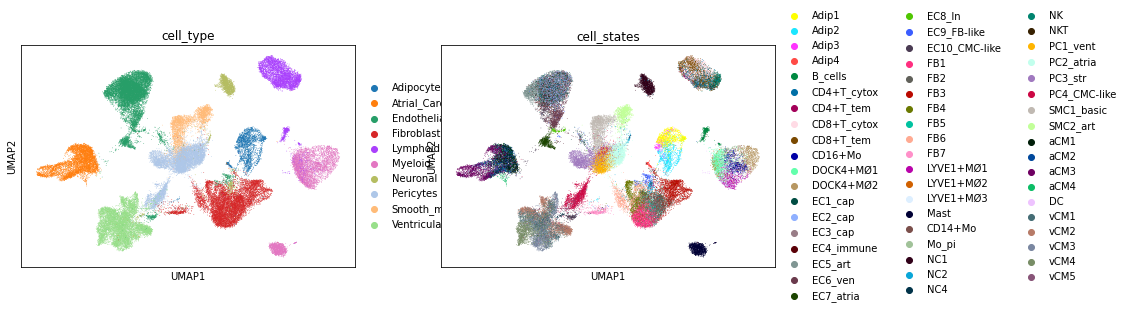

In [9]:
adata = sc.read(DATA_DIR+'processed/Litvinukova2020.h5ad')
sc.pl.umap(adata,color=["cell_type","cell_states"])

# Add positive only quantiles and expression penalties

In [ ]:
#TODO: adjust spapros imports to newest spapros version 

######  Madissoon2019  ######


normalizing counts per cell
    finished (0:00:00)


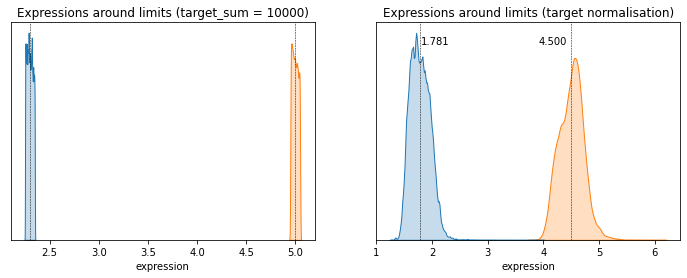

In [3]:
from spapros.util import util

for dataset in ['Madissoon2019']:#,'Meyer5loc2021','Krasnow2020','Asp2019']:
    print("###### ", dataset, " ######")
    adata = sc.read(DATA_DIR+f'processed/{dataset}.h5ad')
    #for q in [0.8,0.85,0.9,0.95,0.99]:
    #    print(f"Calculate quantiles {q}")
    #    get_expression_quantile(adata,q=q,log1p=True,zeros_to_nan=True)
        
    lower_th, upper_th = util.transfered_expression_thresholds(adata,lower=2.3,upper=5,tolerance=0.05,target_sum=10000,output_path=None,plot=True)
    factor = 1
    var = [factor*0.1,factor*0.5]
    penalty = util.plateau_penalty_kernel(var=var,x_min=lower_th,x_max=upper_th)
    adata.var['expression_penalty'] = penalty(adata.var[f'quantile_0.99'])
    penalty = util.plateau_penalty_kernel(var=var,x_min=None,x_max=upper_th)
    adata.var['expression_penalty_upper'] = penalty(adata.var[f'quantile_0.99'])
    penalty = util.plateau_penalty_kernel(var=var,x_min=lower_th,x_max=None)
    adata.var['expression_penalty_lower'] = penalty(adata.var[f'pos_quantile_0.9'])

    if not scipy.sparse.issparse(adata.X):
        adata.X = scipy.sparse.csr_matrix(adata.X)
    adata.write(DATA_DIR+f'processed/{dataset}.h5ad')